## Import

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, PReLU
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras_lr_multiplier import LRMultiplier
from skimage import measure
import matplotlib.pyplot as plt
import PIL.Image as pilimg
import math
import prepare_sub_image as ps
import cv2
import numpy as np
from scipy import io
from collections import defaultdict

Using TensorFlow backend.


## Metrics

In [3]:
def psnr(target, ref):
    
    target_data = np.array(target, dtype = float)
    ref_data = np.array(ref, dtype = float)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    rmse = math.sqrt(np.mean(diff**2))
    
    return 20 * math.log10(255/rmse)

def ssim(target, ref):
    target_data = np.array(target)
    ref_data = np.array(ref)
    
    (score, diff) = measure.compare_ssim(target_data, ref_data, full = True, multichannel=True)
    
    return score

## Model

In [4]:
def model():
    
    
    FSRCNN = Sequential()
    FSRCNN.add(Conv2D(nb_filter = 56, nb_row = 5, nb_col = 5, init = 'glorot_uniform',
                    border_mode = 'same', bias_initializer = 'zeros',
                     input_shape = (None, None, 1), name = 'layer_1'))
    FSRCNN.add(PReLU(alpha_initializer = 'zeros', shared_axes = [1,2]))
    FSRCNN.add(Conv2D(nb_filter = 12, nb_row = 1, nb_col = 1, init = 'glorot_uniform',
                    border_mode = 'same', bias_initializer = 'zeros', name = 'layer_2'))
    FSRCNN.add(PReLU(alpha_initializer = 'zeros', shared_axes = [1,2]))
    FSRCNN.add(Conv2D(nb_filter = 12, nb_row = 3, nb_col = 3, init = 'glorot_uniform',
                    border_mode = 'same', bias_initializer = 'zeros', name = 'layer_3'))
    FSRCNN.add(PReLU(alpha_initializer = 'zeros', shared_axes = [1,2]))
    FSRCNN.add(Conv2D(nb_filter = 12, nb_row = 3, nb_col = 3, init = 'glorot_uniform',
                    border_mode = 'same', bias_initializer = 'zeros', name = 'layer_4'))
    FSRCNN.add(PReLU(alpha_initializer = 'zeros', shared_axes = [1,2]))
    FSRCNN.add(Conv2D(nb_filter = 12, nb_row = 3, nb_col = 3, init = 'glorot_uniform',
                    border_mode = 'same', bias_initializer = 'zeros', name = 'layer_5'))
    FSRCNN.add(PReLU(alpha_initializer = 'zeros', shared_axes = [1,2]))
    FSRCNN.add(Conv2D(nb_filter = 12, nb_row = 3, nb_col = 3, init = 'glorot_uniform',
                    border_mode = 'same', bias_initializer = 'zeros', name = 'layer_6'))
    FSRCNN.add(PReLU(alpha_initializer = 'zeros', shared_axes = [1,2]))
    FSRCNN.add(Conv2D(nb_filter = 56, nb_row = 1, nb_col = 1, init = 'glorot_uniform',
                    border_mode = 'same', bias_initializer = 'zeros', name = 'layer_7'))
    FSRCNN.add(PReLU(alpha_initializer = 'zeros', shared_axes = [1,2]))
    
    FSRCNN.add(Conv2DTranspose(filters = 1, kernel_size = (9,9), strides = (2,2), bias_initializer = 'zeros',
                              input_shape = (None,None,1), padding = 'same', name = 'layer_8'))
    
    
    FSRCNN.layers[0].trainable = False
    FSRCNN.layers[1].trainable = False
    FSRCNN.layers[2].trainable = False
    FSRCNN.layers[3].trainable = False
    FSRCNN.layers[4].trainable = False
    FSRCNN.layers[5].trainable = False
    FSRCNN.layers[6].trainable = False
    FSRCNN.layers[7].trainable = False
    FSRCNN.layers[8].trainable = False
    FSRCNN.layers[9].trainable = False
    FSRCNN.layers[10].trainable = False
    FSRCNN.layers[11].trainable = False
    FSRCNN.layers[12].trainable = False
    FSRCNN.layers[13].trainable = False
    
    
    FSRCNN.compile(optimizer = LRMultiplier(Adam(lr=0.0005), {'layer_1':1, 'layer_2':1, 'layer_3':1, 'layer_4':1,
                                                             'layer_5':1, 'layer_6':1, 'layer_7':1, 'layer_8':0.1})
                   , loss = 'mean_squared_error', metrics = ['mean_squared_error']) 

    return FSRCNN

## Train & Predict

In [5]:
conv_side = 8
test_set = 'Set5'
scale = 2
#total_history = defaultdict(list)


def train():
    
    fsrcnn_model = model()
    
    #fsrcnn_model.load_weights('checkpoint/FSRCNN_checkpoint_2', by_name = True)
    #fsrcnn_model.load_weights('checkpoint/FSRCNN_checkpoint_3_General100.h5', by_name = True)
    
    fsrcnn_model.load_weights('checkpoint/FSRCNN_checkpoint_2_General100.h5')
    
    print(fsrcnn_model.summary())

    '''
    data, label = ps.read_training_data('training_sample/train_General100aug_2.h5')
    val_data, val_label = ps.read_training_data('training_sample/cross_val_200_2.h5')
    '''
    
    PATH_image = '../Dataset/test/test_mat/{}/scale{}/'.format(test_set, scale)
    IMAGE_PATH = 'output_image/{}/scale{}'.format(test_set, scale)

    names_image = os.listdir(PATH_image)
    names_image = sorted(names_image)
    
    nums = len(names_image)
    
    count = 0
    global total_history
    
    checkpoint_filepath = 'checkpoint/FSRCNN_checkpoint_2_General100.h5'
    checkpoint_callbacks = [ModelCheckpoint(filepath = checkpoint_filepath, monitor = 'val_loss', verbose = 1, mode = 'min', 
                                            save_best_only = True)]
    
    for i in range(0,1):
        '''
        fsrcnn_model.fit(x = data, y = label, batch_size = 128, epochs = 20, verbose = 1,
                       callbacks = checkpoint_callbacks, validation_data = (val_data, val_label), shuffle = True)
        
        fsrcnn_model.save('model_weight/FSRCNN_check_2_91aug_General100.h5')
        '''
        
        count += 1
        
        psnr_fsrcnn = []
        psnr_bicubic = []
        ssim_fsrcnn = []
        ssim_bicubic = []

        
        for i in range(nums):

            INPUT_NAME = IMAGE_PATH + '/' + 'input{}.jpg'.format(i)
            OUTPUT_NAME = IMAGE_PATH + '/' + 'predict{}.jpg'.format(i)

            mat_image = io.loadmat(PATH_image + names_image[i])
            
            hr_img = mat_image['im_hr_ycbcr']
            bicubic_img = mat_image['im_bicubic_ycbcr']
            input_img = mat_image['im_lr_ycbcr']
            
            hr_img_Y = hr_img[:, :, 0]
            bicubic_img_Y = bicubic_img[:, :, 0]
            input_img_Y = input_img[:, :, 0]
            
            hr_img_rgb = mat_image['im_hr_rgb']
            bicubic_img_rgb = mat_image['im_bicubic_rgb']
            input_img_rgb = mat_image['im_lr_rgb']

            shape = input_img.shape
            shape_bi = bicubic_img.shape

            input_Y = np.zeros([1, shape[0], shape[1], 1])
            input_Y[0, :, :, 0] = input_img_Y / 255        

            pre = fsrcnn_model.predict(input_Y, batch_size = 1)
            pre = pre * 255
            pre[pre[:] > 255] = 255
            pre[pre[:] < 0 ] = 0
            

            output_img = np.zeros([shape_bi[0], shape_bi[1], 3])
            output_img[:, :, 0] = pre[0, :, :, 0]
            output_img[:, :, 2] = bicubic_img[:, :, 1]
            output_img[:, :, 1] = bicubic_img[:, :, 2]
            
            output_img_Y = output_img[:, :, 0]
            
            output_BGR = np.zeros([shape_bi[0], shape_bi[1], 3])
            
            output_BGR[:, :, 2] = 1.164 * (output_img[:, :, 0] - 16) + 1.596 * (output_img[:, :, 1] - 128)
            output_BGR[:, :, 1] = 1.164 * (output_img[:, :, 0] - 16) - 0.813 * (output_img[:, :, 1] - 128) - 0.392 * (output_img[:, :, 2] - 128)
            output_BGR[:, :, 0] = 1.164 * (output_img[:, :, 0] - 16) + 2.017 * (output_img[:, :, 2] - 128)
            
            cv2.imwrite(OUTPUT_NAME, output_BGR)
            
            '''
            # RGB Channel에 대해 PSNR 측정 시
            output_img_rgb = np.zeros([shape_bi[0], shape_bi[1], 3])
            output_img_rgb[:, :, 0] = 1.164 * (output_img[:, :, 0] - 16) + 1.596 * (output_img[:, :, 1] - 128)
            output_img_rgb[:, :, 1] = 1.164 * (output_img[:, :, 0] - 16) - 0.813 * (output_img[:, :, 1] - 128) - 0.392 * (output_img[:, :, 2] - 128)
            output_img_rgb[:, :, 2] = 1.164 * (output_img[:, :, 0] - 16) + 2.017 * (output_img[:, :, 2] - 128)
            '''
            
            # YCrCb Channel에서 Y에 대해 PSNR 측정 시
            hr_img_measure = hr_img_Y[conv_side:-conv_side, conv_side:-conv_side]
            bicubic_img_measure = bicubic_img_Y[conv_side:-conv_side, conv_side:-conv_side]
            output_img_measure = output_img_Y[conv_side:-conv_side, conv_side:-conv_side]
            
            '''
            # RGB Channel에 대해 PSNR 측정 시
            hr_img_measure = hr_img_rgb[conv_side:-conv_side, conv_side:-conv_side, :]
            bicubic_img_measure = bicubic_img_rgb[conv_side:-conv_side, conv_side:-conv_side, :]
            output_img_measure = output_img_rgb[conv_side:-conv_side, conv_side:-conv_side, :]
            '''
            
            psnr_bicubic_one = psnr(bicubic_img_measure, hr_img_measure)
            ssim_bicubic_one = ssim(bicubic_img_measure, hr_img_measure)

            psnr_fsrcnn_one = psnr(output_img_measure, hr_img_measure)
            ssim_fsrcnn_one = ssim(output_img_measure, hr_img_measure)
            
            print(i + 1)
            print('bicubic: ', psnr_bicubic_one, 'ssim: ', ssim_bicubic_one)
            print('fsrcnn: ', psnr_fsrcnn_one, 'ssim:', ssim_fsrcnn_one)
                        
            psnr_bicubic.append(psnr_bicubic_one)
            ssim_bicubic.append(ssim_bicubic_one)

            psnr_fsrcnn.append(psnr_fsrcnn_one)
            ssim_fsrcnn.append(ssim_fsrcnn_one)

        psnr_bicubic_final = np.mean(psnr_bicubic)
        ssim_bicubic_final = np.mean(ssim_bicubic)
        
        psnr_fsrcnn_final = np.mean(psnr_fsrcnn)
        ssim_fsrcnn_final = np.mean(ssim_fsrcnn)
        
        
        print('Epochs: ', count)

        print('Bicubic')
        print('PSNR: ', psnr_bicubic_final, 'SSIM: ', ssim_bicubic_final)
        print('FSRCNN')
        print('PSNR: ', psnr_fsrcnn_final, 'SSIM: ', ssim_fsrcnn_final)
        
        
        '''
        for key, value in history.history.items():

            total_history[key] = sum([total_history[key], history.history[key]], [])

            
        length = len(total_history['loss'])

        plt.plot(total_history['loss'])
        plt.plot(total_history['val_loss'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        #plt.xticks(ticks = 1)
        plt.xlim(9, length)
        plt.ylim(0, 0.003)
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        '''


if __name__ == "__main__":
    
    train()
    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Conv2D)             (None, None, None, 56)    1456      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, None, None, 56)    56        
_________________________________________________________________
layer_2 (Conv2D)             (None, None, None, 12)    684       
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, None, None, 12)    12        
_________________________________________________________________
layer_3 (Conv2D)             (None, None, None, 12)    1308      
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, None, None, 12)    12        
_________________________________________________________________
layer_4 (Conv2D)             (None, None, None, 12)   

## Visualization 

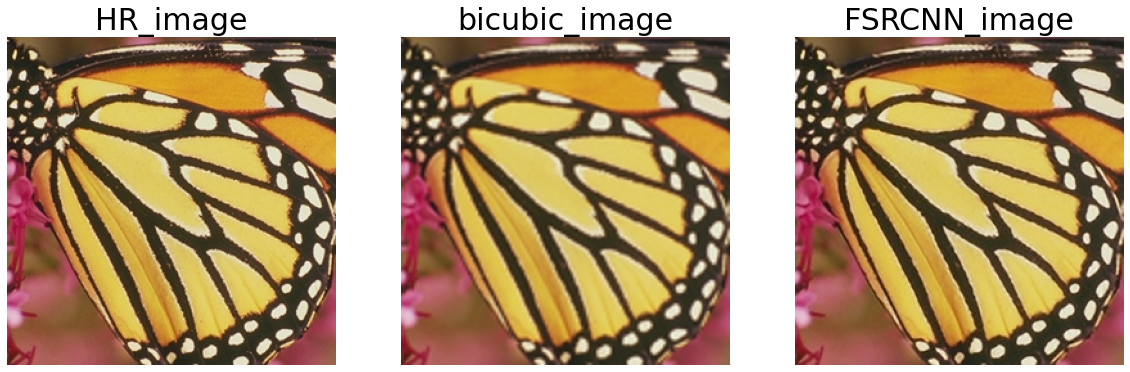

In [6]:
def visualization():
    
    hr_img = pilimg.open('../Dataset/test/test_image/{}/hr_rgb/scale{}/hr_RGB_{}_3.bmp'.format(test_set, scale, scale))
    pix_hr = np.array(hr_img)
    
    bicubic_img = pilimg.open('../Dataset/test/test_image/{}/bicubic_rgb/scale{}/bicubic_RGB_{}_3.bmp'.format(test_set, scale, scale))
    pix_bicubic = np.array(bicubic_img)
    
    fsrcnn_img = pilimg.open('output_image/{}/scale{}/predict2.jpg'.format(test_set, scale))
    pix_srcnn = np.array(fsrcnn_img)
    
    fig = plt.figure(figsize = (20,32))
    rows = 1
    cols = 3
    
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(hr_img)
    ax1.set_title('HR_image', size = 30)
    ax1.axis('off')
    
    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(bicubic_img)
    ax2.set_title('bicubic_image', size = 30)
    ax2.axis('off')
    
    ax3 = fig.add_subplot(rows, cols, 3)
    ax3.imshow(fsrcnn_img)
    ax3.set_title('FSRCNN_image', size = 30)
    ax3.axis('off')
    
    plt.show()
    


if __name__ == "__main__":
    
    visualization()